In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
PATH_DATA = 'drive/Shareddrives/DSF_ARG/PrimerWorkShop/data/'



# Workshop de Python

Cargamos datasets con información de admisiones a hospitales de enfermos de diabetes. El objetivo es, una vez limpiado el dataset, estudiarlo para extraer el máximo número de insights de los datos.



## Información sobre los datos

* Encounter ID 
    - ID único de la admisión de un paciente
* Patient number 
    - ID único de paciente
* Race 
    - Raza
* Gender
    - Sexo
* Age
    - Edad (en intervalos de 10 años)
    
* Weight
    - Peso en libras
* Admission type 
    - Identificador del tipo de admisión 
* Discharge disposition
    - Identificador del tipo de alta 
* Admission source
    - Identificador de la fuente de admisión 
* Time in hospital 
    - Número de días que han pasado entre admission y discharge (admisión y alta)
* Payer code
    - Identificador del código de pago
* Medical specialty
    - Identificador de la especialidad médica donde es ingresado el paciente
* Number of lab procedures 
    - Número de análisis en laboratorio que se han llevado a cabo durante el ingreso del paciente
* Number of procedures 
    - Número de procedimientos (diferentes a los análisis en laboratorio) que se han llevado a cabo durante el ingreso del paciente
* Number of medications
    - Número de nombres de medicamentos distintos que se hayan administrado al paciente durante su ingreso
* Number of outpatient visits
    - Número de visitas como paciente externo (no ingresado, por ejemplo) que ha tenido el paciente durante el año antes de esta admisión
* Number of emergency
    - Numero de visitas de emergencia del paciente durante el año antes de esta admisión
* Number of inpatient visits 
    - Número de visitas en las que ha estado ingresado el paciente durante el año antes de esta admisión
* Diagnosis 1 
    - Diagnóstico primario (codificado como los tres primeros dígitos del ICD9)
    - Descripción de los códigos ICD9: http://icd9.chrisendres.com/index.php?action=contents
* Diagnosis 2 
    - Diagnóstico secundario (codificado como los tres primeros dígitos del ICD9)
    - Descripción de los códigos ICD9: http://icd9.chrisendres.com/index.php?action=contents
* Diagnosis 3 
    - Diagnóstico adicional (codificado como los tres primeros dígitos del ICD9)
    - Descripción de los códigos ICD9: http://icd9.chrisendres.com/index.php?action=contents
* Number of diagnoses 
    - Número de diagnósticos que se han introducido al sistema
* Glucose serum test result 
    - Indica el rango del resultado de la prueba de glucosa, o si no se llevó a cabo la prueba. Valores: “>200,” “>300,” “normal,” y “none” si no se realizó la prueba
* A1c test result
    - Indica el rango del resultado de la prueba de hemoglobina A1c, o si no se llevó a cabo la prueba. Valores: “>8” si el resultado fue mayor del 8%, “>7” si el resultado fue mayor del 7% pero menor del 8%, “normal” si el resultado fue menor del 7%, y “none” si no se realizó la prueba.
* Change of medications 
    - Indica si ha habido un cambio en la medicación para la diabetes (tanto en la dosis como en el propio medicamento)
* Diabetes medications 
    - Indica si ha el paciente toma medicación para la diabetes
* 24 features for medications
    - Para los nombres genéricos de los medicamentos metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, sitagliptin, insulin, glyburide-metformin, glipizide-metformin, glimepiridepioglitazone, metformin-rosiglitazone, y metforminpioglitazone, la variable indica si se prescribió o no el medicamento durante la visita del paciente
    - Valores: “up” si se subió la dosis durante la visita, “down” si se bajó la dosis, “steady” si la dosis no cambió, y “no” si no se prescribió el medicamento
* Readmitted 
    - Indica cuántos días ha tardado el paciente en volver al hospital y ser readmitido. Valores: “<30” si el paciente fue readmitido en menos de 30 días, “>30” si el paciente fue readmitido en más de 30 días, y “No” si el paciente no ha sido readmitido



## Cargar librerías

In [3]:
%matplotlib inline

import re
import random
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
sns.set(color_codes=True)

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score, roc_curve, auc, silhouette_score, recall_score, precision_score, confusion_matrix, make_scorer, accuracy_score
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier



## Lectura de datos

In [4]:
diabetes = pd.read_csv(PATH_DATA+'diabetic_data.csv', sep=',', header=0, na_values= '?')
admission_source = pd.read_csv(PATH_DATA+'admission_source_id.csv', sep=',', header=0, na_values= '?')
admission_type = pd.read_csv(PATH_DATA+'admission_type_id.csv', sep=',', header=0, na_values= '?')
discharge_disposition = pd.read_csv(PATH_DATA+'discharge_disposition_id.csv', sep=',', header=0, na_values= '?')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)




### comprobar correcta lectura de los datos

In [5]:
diabetes.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [6]:
admission_source.head()

,admission_source_id,description
0,1,Physician Referral
1,2,Clinic Referral
2,3,HMO Referral
3,4,Transfer from a hospital
4,5,Transfer from a Skilled Nursing Facility (SNF)


In [7]:
admission_type.head()

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available


In [8]:
discharge_disposition.head()

,discharge_disposition_id,description
0,1,Discharged to home
1,2,Discharged/transferred to another short term h...
2,3,Discharged/transferred to SNF
3,4,Discharged/transferred to ICF
4,5,Discharged/transferred to another type of inpa...




### juntar todos los datos en el mismo DataFrame

In [9]:
admission_source.rename(columns= {'description': 'admission_source_desc'}, inplace= True)
admission_type.rename(columns= {'description': 'admission_type_desc'}, inplace= True)
discharge_disposition.rename(columns= {'description': 'discharge_disposition_desc'}, inplace= True)

In [10]:
diabetes_total = pd.merge(diabetes, admission_source, on= 'admission_source_id', how= 'left')
diabetes_total = pd.merge(diabetes_total, admission_type, on= 'admission_type_id', how= 'left')
diabetes_total = pd.merge(diabetes_total, discharge_disposition, on= 'discharge_disposition_id', how= 'left')



### estudiar las dimensiones del dataset

In [11]:
diabetes_total.shape

(101766, 53)



## Data Wrangling



### cambiar los nombres de las columnas para que cumplan buenas prácticas

In [12]:
new_names= {'time_in_hospital': 'num_days_in_hospital',
            'number_outpatient': 'num_outpatient',
            'number_emergency': 'num_emergency',
            'number_inpatient': 'num_inpatient',
            'number_diagnoses': 'num_diagnoses',
            'diag_1': 'cd_diag_1',
            'diag_2': 'cd_diag_2',
            'diag_3': 'cd_diag_3',
            'max_glu_serum': 'glucose_result',
            'A1Cresult': 'a1c_result',
            'metformin': 'cd_med_metformin',
            'repaglinide': 'cd_med_repaglinide',
            'nateglinide': 'cd_med_nateglinide',
            'chlorpropamide': 'cd_med_chlorpropamide',
            'glimepiride': 'cd_med_glimepiride',
            'acetohexamide': 'cd_med_acetohexamide',
            'glipizide': 'cd_med_glipizide',
            'glyburide': 'cd_med_glyburide',
            'tolbutamide': 'cd_med_tolbutamide',
            'pioglitazone': 'cd_med_pioglitazone',
            'rosiglitazone': 'cd_med_rosiglitazone',
            'acarbose': 'cd_med_acarbose',
            'miglitol': 'cd_med_miglitol',
            'troglitazone': 'cd_med_troglitazone',
            'tolazamide': 'cd_med_tolazamide',
            'examide': 'cd_med_examide',
            'citoglipton': 'cd_med_citoglipton',
            'insulin': 'cd_med_insulin',
            'glyburide-metformin': 'cd_med_glyburide_metformin',
            'glipizide-metformin': 'cd_med_glipizide_metformin',
            'glimepiride-pioglitazone': 'cd_med_glimepiride_pioglitazone',
            'metformin-rosiglitazone': 'cd_med_metformin_rosiglitazone',
            'metformin-pioglitazone': 'cd_med_metformin_pioglitazone',
            'change': 'flag_change_medication',
            'diabetesMed': 'flag_take_medication',
            'readmitted': 'cd_days_readmitted'}

diabetes_total.rename(new_names, axis= 1, inplace= True)



### estudiar el formato de las variables, ver cuáles se deberían modificar y modificarlas cuando se considere oportuno

In [13]:
# Estandarizo los valores de las descripciones de la fuente, tipo de admisión y como se fue la persona
diabetes_total[['admission_source_desc','admission_type_desc','discharge_disposition_desc']] = (
    diabetes_total[['admission_source_desc','admission_type_desc','discharge_disposition_desc']]
    .apply(lambda x: x
           .str.casefold()
           .str.strip()
           .str.replace('\s+','_')
           .str.replace('[^a-z_]', ''))
)

# Categorias ordinales

diabetes_total['cat_age'] = pd.Categorical(diabetes_total['age'], ordered= True)
diabetes_total['cat_weight'] = pd.Categorical(diabetes_total['weight'], categories= ['[0-25)','[25-50)','[50-75)','[75-100)','[100-125)','[125-150)','[150-175)','[175-200)','>200'], ordered= True)
diabetes_total['cat_glucose_result'] = pd.Categorical(diabetes_total['glucose_result'], categories= ['Norm','>200','>300'], ordered= True)
diabetes_total['cat_a1c_result'] = pd.Categorical(diabetes_total['a1c_result'], categories= ['Norm','>7','>8'], ordered= True)
diabetes_total['cat_days_readmitted'] = pd.Categorical(diabetes_total['cd_days_readmitted'], categories= ['<30','>30','NO'], ordered= True)
diabetes_total['cat_race'] = pd.Categorical(diabetes_total['race'])
diabetes_total['cat_payer_code'] = pd.Categorical(diabetes_total['payer_code'])
diabetes_total['cat_medical_specialty'] = pd.Categorical(diabetes_total['medical_specialty'])
diabetes_total['flag_change_medication'] = np.where(diabetes_total['flag_change_medication'] == 'Ch', 1, 0)
diabetes_total['flag_take_medication'] = np.where(diabetes_total['flag_take_medication'] == 'Yes', 1, 0)
diabetes_total.loc[diabetes_total['admission_source_desc'].isin(['none','not_mapped', 'not_available']),'admission_source_desc'] = np.NaN
diabetes_total.loc[diabetes_total['admission_type_desc'].isin(['none','not_mapped', 'not_available']),'admission_type_desc'] = np.NaN
diabetes_total.loc[diabetes_total['discharge_disposition_desc'].isin(['none','not_mapped', 'not_available']),'discharge_disposition_desc'] = np.NaN
diabetes_total.loc[diabetes_total['gender'] == 'Unknown/Invalid','gender'] = np.NaN

prescriptions_cat = (
                      diabetes_total
                      .filter(regex= 'cd_med')
                      .apply(lambda x: pd.Categorical(x, categories= ['No','Down','Steady','Up'], ordered= True))
                      .rename(lambda x: x.replace('cd_med','cat_med'), axis= 1)
                    )

diabetes_total = pd.concat([diabetes_total,prescriptions_cat], axis= 1)



### estudiar si hay registros repetidos

In [14]:
diabetes_total.duplicated().any() # No hay registros repitos

False

### Me quedo con base a estudiar

In [15]:
vars_categorias_creadas = list(diabetes_total.filter(regex= 'cat_').columns.values)
vars_descripciones = ['admission_source_desc', 'admission_type_desc','discharge_disposition_desc']
vars_flags = ['flag_change_medication', 'flag_take_medication']
vars_diagnosticos= ['cd_diag_1','cd_diag_2', 'cd_diag_3','num_diagnoses']
vars_resto = ['encounter_id', 'patient_nbr','gender','num_days_in_hospital',
              'medical_specialty','num_lab_procedures', 'num_procedures',
              'num_medications','num_outpatient','num_emergency','num_inpatient']

diabetes_processed = diabetes_total[vars_resto + vars_categorias_creadas + vars_descripciones + vars_diagnosticos + vars_flags].copy()



### estudiar si hay variables que siempre o prácticamente siempre toman el mismo valor: tomar siempre el mismo valor no aporta información al modelo

#### Categoricas

In [16]:
# Reviso las cantidades de cada variable categórica

diabetes_categoria = diabetes_processed.select_dtypes(include = ["category"])

for i, column in enumerate(diabetes_categoria):
  cantidades = diabetes_processed[column].sort_values().value_counts()
  print(cantidades)

[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: cat_age, dtype: int64
[75-100)     1336
[50-75)       897
[100-125)     625
[125-150)     145
[25-50)        97
[0-25)         48
[150-175)      35
[175-200)      11
>200            3
Name: cat_weight, dtype: int64
Norm    2597
>200    1485
>300    1264
Name: cat_glucose_result, dtype: int64
>8      8216
Norm    4990
>7      3812
Name: cat_a1c_result, dtype: int64
NO     54864
>30    35545
<30    11357
Name: cat_days_readmitted, dtype: int64
Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: cat_race, dtype: int64
MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2533
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1
Name: cat_

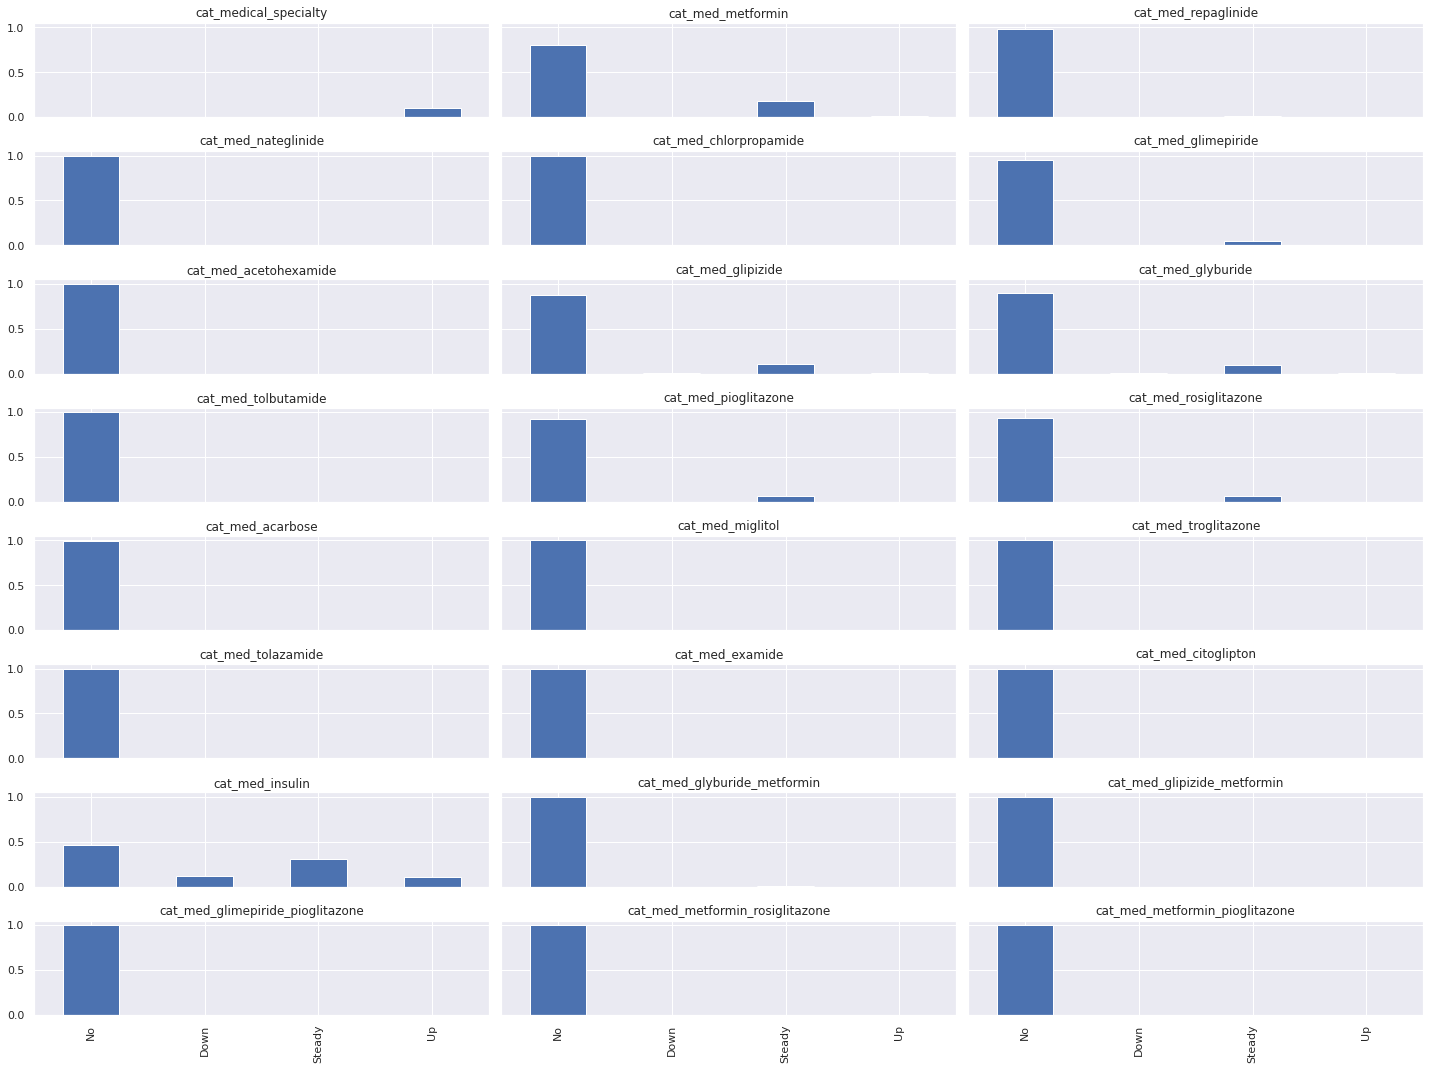

In [17]:
columnas = diabetes_processed.filter(regex= 'cat_med').columns.values

fig, ax = plt.subplots(nrows= 8, ncols= 3, sharex= True, sharey= True)

matriz = [(i,j) for i in range(8) for j in range(3)]

for i, coord in enumerate(matriz):
  
    if i <= len(columnas):
      diabetes_processed[columnas[i]].value_counts(normalize= True).sort_index().plot.bar(ax= ax[coord], title= columnas[i])

fig.set_size_inches(20,15)
plt.tight_layout(1);

#### Numericas

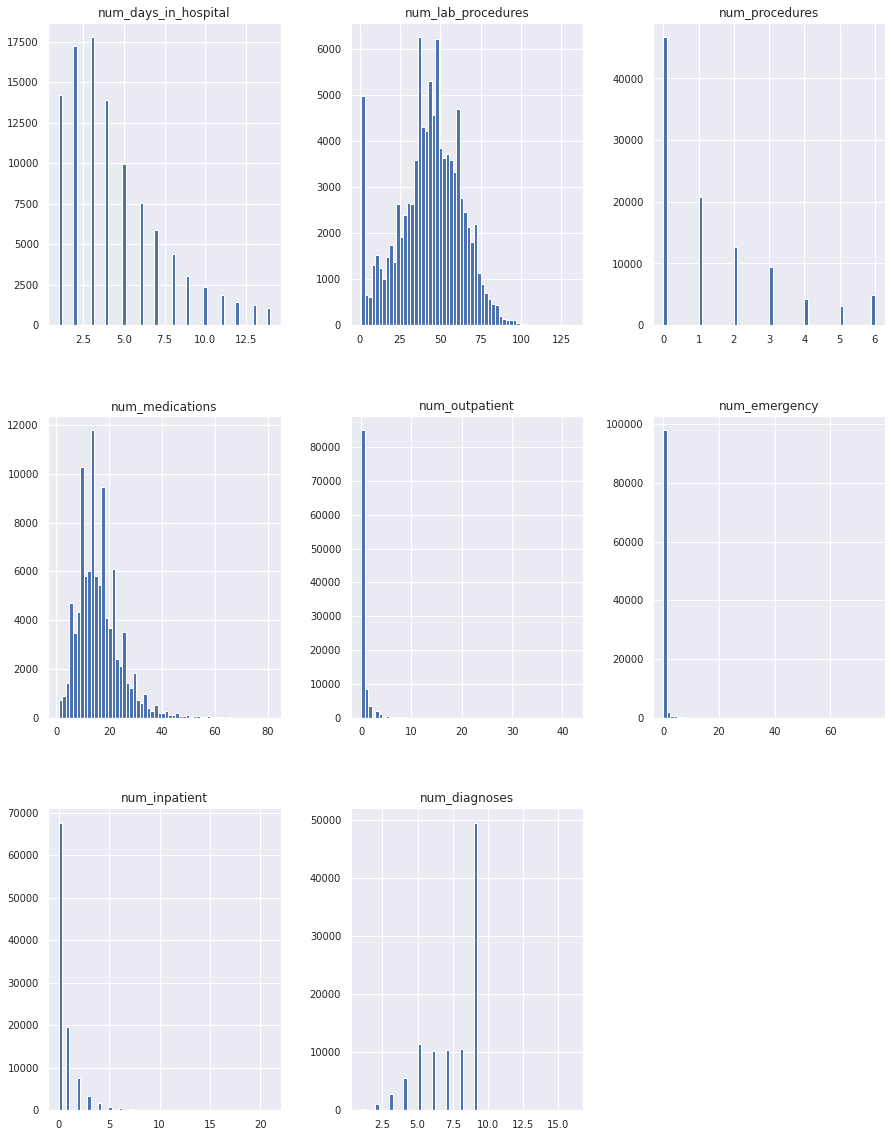

In [18]:
#Selecciono variables numericas
diabetes_num = diabetes_processed.select_dtypes(include = ["number"]).drop(columns= ['encounter_id','patient_nbr','flag_change_medication','flag_take_medication'])

#Arma histogramas para todas las variables numericas
diabetes_num.hist(figsize=(15, 20), bins=60, xlabelsize=10, ylabelsize=10);



### estudiar los nulos en el dataset

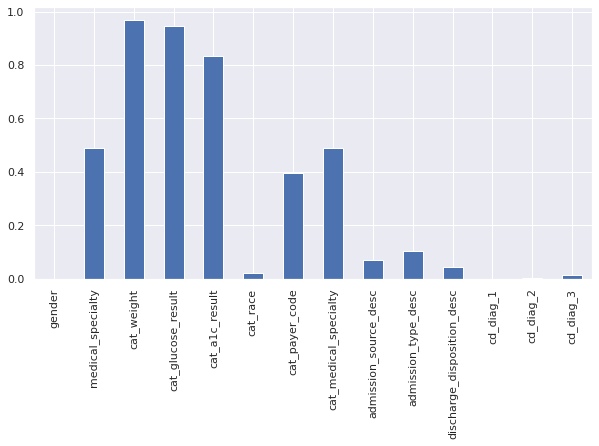

In [19]:
diabetes_processed.isnull().mean()[(diabetes_processed.isnull().mean() > 0)].plot.bar(figsize= (10,5))

In [20]:
diabetes_processed.isnull().sum()[(diabetes_processed.isnull().sum() > 0)].sort_values(ascending= False)

cat_weight                    98569
cat_glucose_result            96420
cat_a1c_result                84748
cat_medical_specialty         49949
medical_specialty             49949
cat_payer_code                40256
admission_type_desc           10396
admission_source_desc          7067
discharge_disposition_desc     4680
cat_race                       2273
cd_diag_3                      1423
cd_diag_2                       358
cd_diag_1                        21
gender                            3
dtype: int64

In [21]:
# Elimino los registros de genero y diagnostico 1 que son nulos y son pocos

diabetes_processed = diabetes_processed.loc[~(diabetes_processed['gender'].isnull() | diabetes_processed['cd_diag_1'].isnull()),:]



### estudiar los outliers

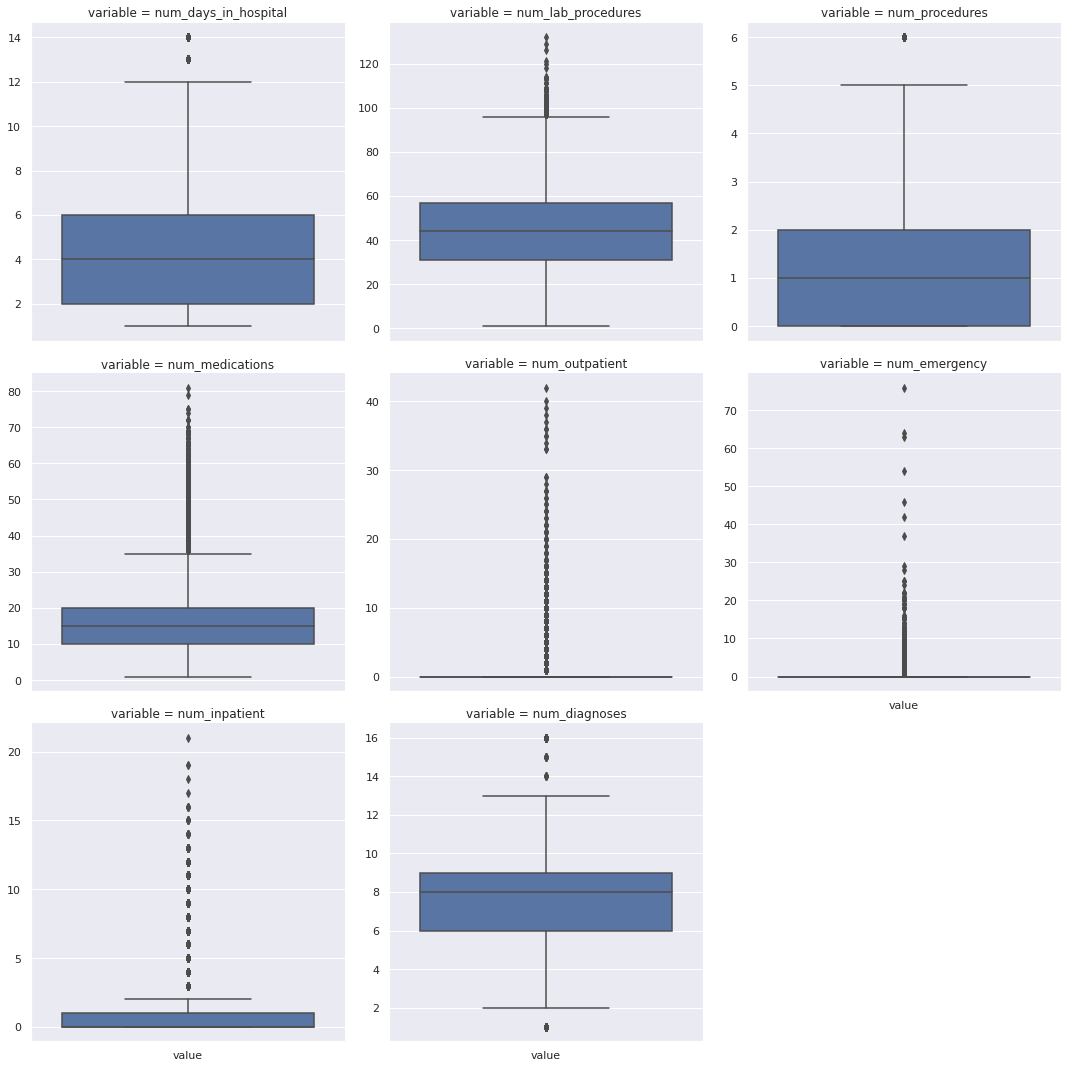

In [22]:
sns.catplot(data= diabetes_num.melt(), kind= 'box', col= 'variable', col_wrap= 3, sharey= False)

In [23]:
percentiles = diabetes_num.quantile([0,0.01,0.5,0.9,0.99,1], numeric_only=True)
percentiles.T

,0.00,0.01,0.50,0.90,0.99,1.00
num_days_in_hospital,1.0,1.0,4.0,9.0,14.0,14.0
num_lab_procedures,1.0,1.0,44.0,67.0,85.0,132.0
num_procedures,0.0,0.0,1.0,4.0,6.0,6.0
num_medications,1.0,3.0,15.0,26.0,43.0,81.0
num_outpatient,0.0,0.0,0.0,1.0,5.0,42.0
num_emergency,0.0,0.0,0.0,1.0,3.0,76.0
num_inpatient,0.0,0.0,0.0,2.0,6.0,21.0
num_diagnoses,1.0,2.0,8.0,9.0,9.0,16.0


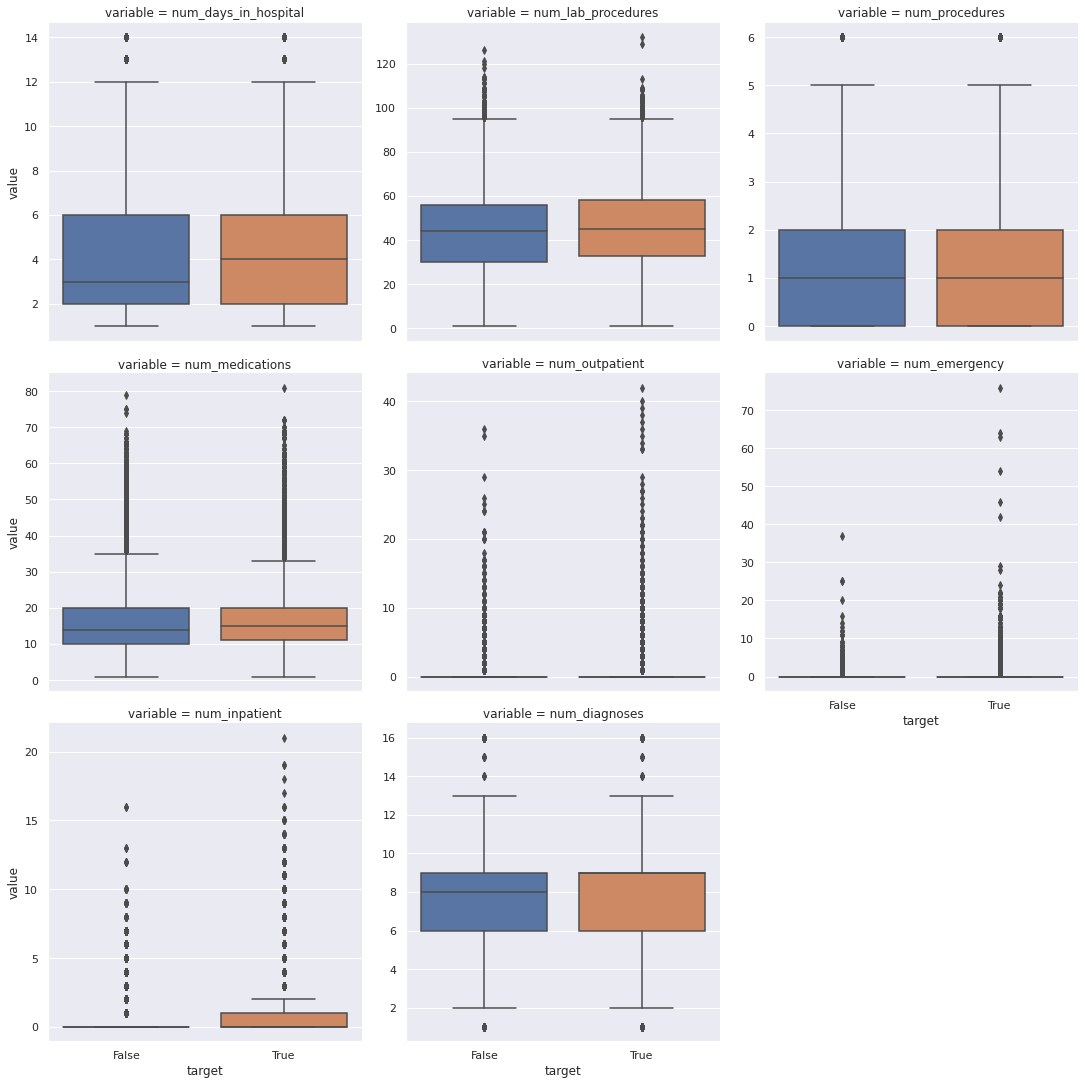

In [24]:
boxplot_data = diabetes_processed.assign(target= diabetes_processed['cat_days_readmitted'] != 'NO')[np.concatenate((['target'],diabetes_num.columns.values))].melt(id_vars= 'target')

sns.catplot(x= 'target',
            y= 'value',
            col= 'variable',
            col_wrap= 3,
            data= boxplot_data,
            kind= 'box',
            sharey= False)

In [25]:
# Topeo valores

diabetes_processed['num_lab_procedures'] = np.where(diabetes_processed['num_lab_procedures'] > 85, 85, diabetes_processed['num_lab_procedures'])
diabetes_processed['num_medications'] = np.where(diabetes_processed['num_medications'] > 43, 43, diabetes_processed['num_medications'])
diabetes_processed['num_outpatient'] = np.where(diabetes_processed['num_outpatient'] > 5, 5, diabetes_processed['num_outpatient'])
diabetes_processed['num_emergency'] = np.where(diabetes_processed['num_emergency'] > 3, 3, diabetes_processed['num_emergency'])
diabetes_processed['num_inpatient'] = np.where(diabetes_processed['num_inpatient'] > 6, 6, diabetes_processed['num_inpatient'])



### crear variables dummy en caso que sea conveniente

In [26]:
## Dummies generales

diabetes_processed['flag_female'] = np.where(diabetes_processed['gender'] == 'Female', 1, 0)
diabetes_processed['flag_lab_procedures'] = np.where(diabetes_processed['num_lab_procedures']  > 0, 1, 0)
diabetes_processed['flag_outpatient'] = np.where(diabetes_processed['num_outpatient']  > 0, 1, 0)
diabetes_processed['flag_emergency'] = np.where(diabetes_processed['num_emergency']  > 0, 1, 0)
diabetes_processed['flag_num_procedures'] = np.where(diabetes_processed['num_procedures']  > 0, 1, 0)
diabetes_processed['flag_inpatient'] = np.where(diabetes_processed['num_inpatient']  > 0, 1, 0)

diabetes_processed = pd.concat([diabetes_processed, pd.get_dummies(diabetes_processed['cat_race'], drop_first= True, prefix= 'flag_race', dummy_na= True)], axis= 1)
diabetes_processed = pd.concat([diabetes_processed, pd.get_dummies(diabetes_processed['cat_payer_code'], drop_first= True, prefix= 'flag_payer', dummy_na= True)], axis= 1)

In [27]:
## Creo dummies por diagnostico

rng_diagnosticos = {'infec_parasitic': np.arange(1,140),
                    'neoplasms': np.arange(140,240),
                    'endoc_nutr': np.arange(240,280),
                    'blood': np.arange(280,290),
                    'metal': np.arange(290,320),
                    'nervous_sys': np.arange(320,390),
                    'circ_sys': np.arange(390,460),
                    'resp_sys': np.arange(460,520),
                    'dige_sys': np.arange(520,580),
                    'geni_sys': np.arange(580,630),
                    'pregnant': np.arange(630,680),
                    'skin': np.arange(680,710),
                    'muscles': np.arange(710,740),
                    'congenital': np.arange(740,760),
                    'perital': np.arange(760,780),
                    'symptoms_ill': np.arange(780,800),
                    'injury_poison': np.arange(800,1000)}
                    
for i in range(3):
  for d in rng_diagnosticos:
    diabetes_processed['flag_diag_'+str(i+1)+'_'+d] = np.where(pd.to_numeric(diabetes_processed['cd_diag_'+str(i+1)].str[:3], errors= 'coerce').isin(rng_diagnosticos[d]), 1, 0)
    
  diabetes_processed['flag_diag_'+str(i+1)+'_v'] = np.where(diabetes_processed['cd_diag_'+str(i+1)].str[:1] == 'V', 1, 0)
  diabetes_processed['flag_diag_'+str(i+1)+'_e'] = np.where(diabetes_processed['cd_diag_'+str(i+1)].str[:1] == 'E', 1, 0)

## Creo dummies por diagnostico separado(> 1% de los casos)
diag_1_dummies = ['428', '414', '786', '410', '486', '427', '491', '715', '682', '434',
                  '780', '996', '276', '38', '250', '599', '584', 'V57', '250', '518',
                  '820', '577', '493']
diag_2_dummies = ['276', '428', '250', '427', '401', '496', '599', '403', '414', '411',
                  '250', '707', '585', '584', '491', '250', '285', '780', '425',
                  '682', '486', '518', '424', '413']
diag_3_dummies = ['250', '401', '276', '428', '427', '414', '496', '403', '585', '272',
                  '599', 'V45', '250', '707', '780', '285', '425', '250', '424']

for i in diag_1_dummies:
  diabetes_processed['flag_diag_1_n'+str(i)] = np.where(diabetes_processed['cd_diag_1'].str[:3].isin(diag_1_dummies), 1, 0)
for i in diag_2_dummies:
  diabetes_processed['flag_diag_2_n'+str(i)] = np.where(diabetes_processed['cd_diag_2'].str[:3].isin(diag_2_dummies), 1, 0)
for i in diag_3_dummies:
  diabetes_processed['flag_diag_3_n'+str(i)] = np.where(diabetes_processed['cd_diag_3'].str[:3].isin(diag_3_dummies), 1, 0)

In [28]:
diabetes_processed = pd.concat([diabetes_processed,
                                pd.get_dummies(diabetes_processed['admission_source_desc'], prefix= 'flag_asource', dummy_na= True, drop_first= True)],
                               axis= 1)
diabetes_processed = pd.concat([diabetes_processed,
                                pd.get_dummies(diabetes_processed['admission_type_desc'], prefix= 'flag_atype', dummy_na= True, drop_first= True)],
                               axis= 1)
diabetes_processed = pd.concat([diabetes_processed,
                                pd.get_dummies(diabetes_processed['discharge_disposition_desc'], prefix= 'flag_dis', dummy_na= True, drop_first= True)],
                               axis= 1)



### estudiar que todas las variables ahora sí tengan el formato y contenido adecuado. si todavía no, arreglarlas.

In [29]:
pd.set_option('display.max_rows', 1000, 'display.max_columns', 1000)
diabetes_processed.info(verbose= True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101742 entries, 0 to 101765
Data columns (total 240 columns):
 #   Column                                                                                                            Dtype   
---  ------                                                                                                            -----   
 0   encounter_id                                                                                                      int64   
 1   patient_nbr                                                                                                       int64   
 2   gender                                                                                                            object  
 3   num_days_in_hospital                                                                                              int64   
 4   medical_specialty                                                                                                 o



### antes de estudiar el comportamiento de las variables, veremos si hay alguna variable derivada a crear

In [30]:
## Las ordinales las coloco como numericas

# Medicamentos
diabetes_processed = pd.concat([diabetes_processed,
                                diabetes_processed.filter(regex= 'cat_med_').apply(lambda x: x.cat.codes).rename(lambda x: x.replace('cat_med','num_dosis'), axis= 1)],
                               axis= 1)

diabetes_processed['num_medicamentos'] = diabetes_processed.filter(regex= 'num_dosis_').apply(lambda x: x > 0).sum(axis= 1)
diabetes_processed['num_medicamentos_down'] = diabetes_processed.filter(regex= 'num_dosis_').apply(lambda x: x == 1).sum(axis= 1)
diabetes_processed['num_medicamentos_steady'] = diabetes_processed.filter(regex= 'num_dosis_').apply(lambda x: x == 2).sum(axis= 1)
diabetes_processed['num_medicamentos_up'] = diabetes_processed.filter(regex= 'num_dosis_').apply(lambda x: x == 3).sum(axis= 1)

diabetes_processed['num_max_dosis_medicamentos'] = diabetes_processed.filter(regex= 'num_dosis_').max(axis= 1)

# Resto
diabetes_processed[['num_age','num_weight','num_glucose_result','num_a1c_result']] = diabetes_processed[['cat_age','cat_weight','cat_glucose_result','cat_a1c_result']].apply(lambda x: x.cat.codes)

# NAs de numericas
diabetes_processed['flag_na_weight'] = np.where(diabetes_processed['num_weight'] == -1, 1, 0)
diabetes_processed['flag_na_glucose_result'] = np.where(diabetes_processed['num_glucose_result'] == -1, 1, 0)
diabetes_processed['flag_na_a1c_result'] = np.where(diabetes_processed['num_a1c_result'] == -1, 1, 0)

### Dataset Final

In [31]:
vars_numericas = ['num_days_in_hospital','num_lab_procedures','num_procedures','num_medications','num_outpatient','num_emergency','num_inpatient','num_diagnoses','num_dosis_metformin','num_dosis_repaglinide','num_dosis_nateglinide','num_dosis_chlorpropamide','num_dosis_glimepiride','num_dosis_acetohexamide','num_dosis_glipizide','num_dosis_glyburide','num_dosis_tolbutamide','num_dosis_pioglitazone','num_dosis_rosiglitazone','num_dosis_acarbose','num_dosis_miglitol','num_dosis_troglitazone','num_dosis_tolazamide','num_dosis_examide','num_dosis_citoglipton','num_dosis_insulin','num_dosis_glyburide_metformin','num_dosis_glipizide_metformin','num_dosis_glimepiride_pioglitazone','num_dosis_metformin_rosiglitazone','num_dosis_metformin_pioglitazone','num_medicamentos','num_medicamentos_down','num_medicamentos_steady','num_medicamentos_up','num_max_dosis_medicamentos','num_age','num_weight','num_glucose_result','num_a1c_result']
vars_flag = ['flag_na_weight','flag_na_glucose_result','flag_na_a1c_result','flag_change_medication','flag_take_medication','flag_female','flag_lab_procedures','flag_outpatient','flag_emergency','flag_diag_1_infec_parasitic','flag_diag_1_neoplasms','flag_diag_1_endoc_nutr','flag_diag_1_blood','flag_diag_1_metal','flag_diag_1_nervous_sys','flag_diag_1_circ_sys','flag_diag_1_resp_sys','flag_diag_1_dige_sys','flag_diag_1_geni_sys','flag_diag_1_pregnant','flag_diag_1_skin','flag_diag_1_muscles','flag_diag_1_congenital','flag_diag_1_perital','flag_diag_1_symptoms_ill','flag_diag_1_injury_poison','flag_diag_1_v','flag_diag_1_e','flag_diag_2_infec_parasitic','flag_diag_2_neoplasms','flag_diag_2_endoc_nutr','flag_diag_2_blood','flag_diag_2_metal','flag_diag_2_nervous_sys','flag_diag_2_circ_sys','flag_diag_2_resp_sys','flag_diag_2_dige_sys','flag_diag_2_geni_sys','flag_diag_2_pregnant','flag_diag_2_skin','flag_diag_2_muscles','flag_diag_2_congenital','flag_diag_2_perital','flag_diag_2_symptoms_ill','flag_diag_2_injury_poison','flag_diag_2_v','flag_diag_2_e','flag_diag_3_infec_parasitic','flag_diag_3_neoplasms','flag_diag_3_endoc_nutr','flag_diag_3_blood','flag_diag_3_metal','flag_diag_3_nervous_sys','flag_diag_3_circ_sys','flag_diag_3_resp_sys','flag_diag_3_dige_sys','flag_diag_3_geni_sys','flag_diag_3_pregnant','flag_diag_3_skin','flag_diag_3_muscles','flag_diag_3_congenital','flag_diag_3_perital','flag_diag_3_symptoms_ill','flag_diag_3_injury_poison','flag_diag_3_v','flag_diag_3_e','flag_diag_1_n428','flag_diag_1_n414','flag_diag_1_n786','flag_diag_1_n410','flag_diag_1_n486','flag_diag_1_n427','flag_diag_1_n491','flag_diag_1_n715','flag_diag_1_n682','flag_diag_1_n434','flag_diag_1_n780','flag_diag_1_n996','flag_diag_1_n276','flag_diag_1_n38','flag_diag_1_n250','flag_diag_1_n599','flag_diag_1_n584','flag_diag_1_nV57','flag_diag_1_n518','flag_diag_1_n820','flag_diag_1_n577','flag_diag_1_n493','flag_diag_2_n276','flag_diag_2_n428','flag_diag_2_n250','flag_diag_2_n427','flag_diag_2_n401','flag_diag_2_n496','flag_diag_2_n599','flag_diag_2_n403','flag_diag_2_n414','flag_diag_2_n411','flag_diag_2_n707','flag_diag_2_n585','flag_diag_2_n584','flag_diag_2_n491','flag_diag_2_n285','flag_diag_2_n780','flag_diag_2_n425','flag_diag_2_n682','flag_diag_2_n486','flag_diag_2_n518','flag_diag_2_n424','flag_diag_2_n413','flag_diag_3_n250','flag_diag_3_n401','flag_diag_3_n276','flag_diag_3_n428','flag_diag_3_n427','flag_diag_3_n414','flag_diag_3_n496','flag_diag_3_n403','flag_diag_3_n585','flag_diag_3_n272','flag_diag_3_n599','flag_diag_3_nV45','flag_diag_3_n707','flag_diag_3_n780','flag_diag_3_n285','flag_diag_3_n425','flag_diag_3_n424','flag_asource_courtlaw_enforcement','flag_asource_emergency_room','flag_asource_extramural_birth','flag_asource_hmo_referral','flag_asource_normal_delivery','flag_asource_physician_referral','flag_asource_sick_baby','flag_asource_transfer_from_a_hospital','flag_asource_transfer_from_a_skilled_nursing_facility_snf','flag_asource_transfer_from_ambulatory_surgery_center','flag_asource_transfer_from_another_health_care_facility','flag_asource_transfer_from_critial_access_hospital','flag_asource_transfer_from_hospital_inptsame_fac_reslt_in_a_sep_claim','flag_asource_nan','flag_atype_emergency','flag_atype_newborn','flag_atype_trauma_center','flag_atype_urgent','flag_atype_nan','flag_dis_discharged_to_home','flag_dis_dischargedtransferred_to_a_federal_health_care_facility','flag_dis_dischargedtransferred_to_a_long_term_care_hospital','flag_dis_dischargedtransferred_to_a_nursing_facility_certified_under_medicaid_but_not_certified_under_medicare','flag_dis_dischargedtransferred_to_another_rehab_fac_including_rehab_units_of_a_hospital_','flag_dis_dischargedtransferred_to_another_short_term_hospital','flag_dis_dischargedtransferred_to_another_type_of_inpatient_care_institution','flag_dis_dischargedtransferred_to_home_under_care_of_home_iv_provider','flag_dis_dischargedtransferred_to_home_with_home_health_service','flag_dis_dischargedtransferred_to_icf','flag_dis_dischargedtransferred_to_snf','flag_dis_dischargedtransferred_within_this_institution_to_medicare_approved_swing_bed','flag_dis_dischargedtransferredreferred_another_institution_for_outpatient_services','flag_dis_dischargedtransferredreferred_to_a_psychiatric_hospital_of_psychiatric_distinct_part_unit_of_a_hospital','flag_dis_dischargedtransferredreferred_to_this_institution_for_outpatient_services','flag_dis_expired','flag_dis_expired_at_home_medicaid_only_hospice','flag_dis_expired_in_a_medical_facility_medicaid_only_hospice','flag_dis_hospice__home','flag_dis_hospice__medical_facility','flag_dis_left_ama','flag_dis_neonate_discharged_to_another_hospital_for_neonatal_aftercare','flag_dis_still_patient_or_expected_to_return_for_outpatient_services','flag_dis_nan',
             'flag_race_Asian', 'flag_race_Caucasian', 'flag_race_Hispanic','flag_race_Other', 'flag_race_nan',
             'flag_payer_CH', 'flag_payer_CM', 'flag_payer_CP', 'flag_payer_DM',
             'flag_payer_FR', 'flag_payer_HM', 'flag_payer_MC', 'flag_payer_MD',
             'flag_payer_MP', 'flag_payer_OG', 'flag_payer_OT', 'flag_payer_PO',
             'flag_payer_SI', 'flag_payer_SP', 'flag_payer_UN', 'flag_payer_WC',
             'flag_payer_nan']

eliminar_vars_ctes = ['num_dosis_chlorpropamide',
                      'num_dosis_acetohexamide',
                      'num_dosis_tolbutamide',
                      'num_dosis_acarbose',
                      'num_dosis_miglitol',
                      'num_dosis_troglitazone',
                      'num_dosis_tolazamide' ,
                      'num_dosis_examide',
                      'num_dosis_citoglipton',
                      'num_dosis_glyburide_metformin',
                      'num_dosis_glipizide_metformin',
                      'num_dosis_glimepiride_pioglitazone',
                      'num_dosis_glimepiride_pioglitazone',
                      'num_dosis_metformin_rosiglitazone']

In [32]:
diabetes_final = diabetes_processed[['cat_days_readmitted','encounter_id','patient_nbr'] + vars_numericas + vars_flag].drop(columns= eliminar_vars_ctes)

In [33]:
diabetes_final.shape

(101742, 222)



# Exploratory Data Analysis



### crear la matriz de correlación

In [34]:
df_numerical_corr = diabetes_final.filter(regex= 'num_').corr(method= 'spearman')



### pintar la matriz de correlación

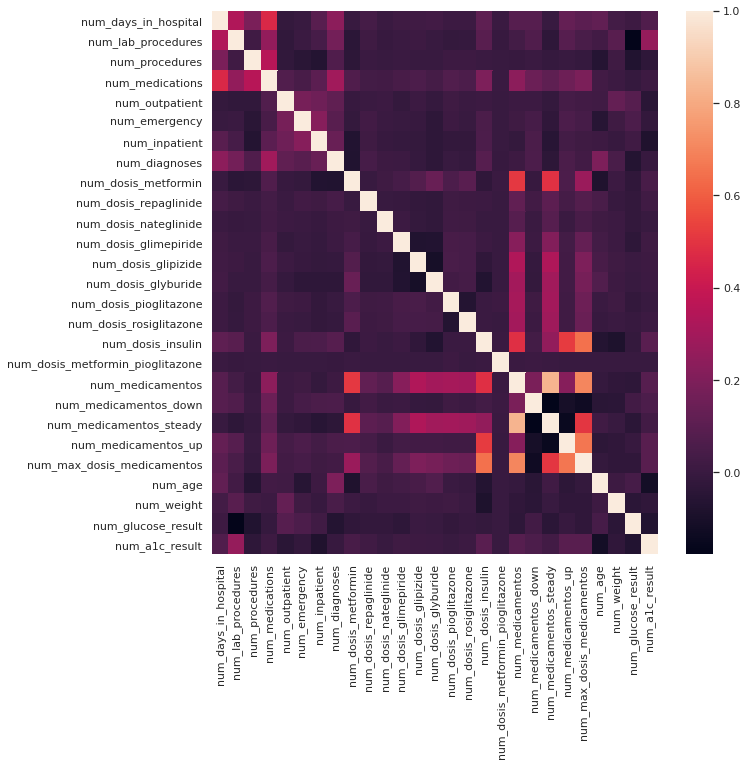

In [35]:
plt.figure(figsize= (10,10))
sns.heatmap(df_numerical_corr)



### determinar qué par de variables están correlacionadas

In [36]:
lista = []
for i in range(df_numerical_corr.shape[0]):
  for j in range(df_numerical_corr.shape[0]):

     coef_corr = df_numerical_corr.iloc[i,j]
     index = df_numerical_corr.index.values[i]
     column = df_numerical_corr.columns.values[j]

     nueva_lista1 = [index, column, coef_corr]
     nueva_lista2 = [column, index, coef_corr]
     if (i != j) & (coef_corr > 0.6) & (nueva_lista1 not in lista) & (nueva_lista2 not in lista):
        lista.append(nueva_lista1)

variables_correlacionadas = pd.DataFrame(lista, columns= ['var1','var2','coef']).drop_duplicates()
variables_correlacionadas.sort_values(by= 'coef', ascending= False)

,var1,var2,coef
1,num_medicamentos,num_medicamentos_steady,0.831751
2,num_medicamentos,num_max_dosis_medicamentos,0.701294
3,num_medicamentos_up,num_max_dosis_medicamentos,0.663305
0,num_dosis_insulin,num_max_dosis_medicamentos,0.646551




### estudiar los pares de variables correlacionadas para quedarse solamente con una del par

In [37]:
top_correlated_vars = list(set([i[0] for i in variables_correlacionadas.iloc[:,:2].values.reshape(-1,1)]))

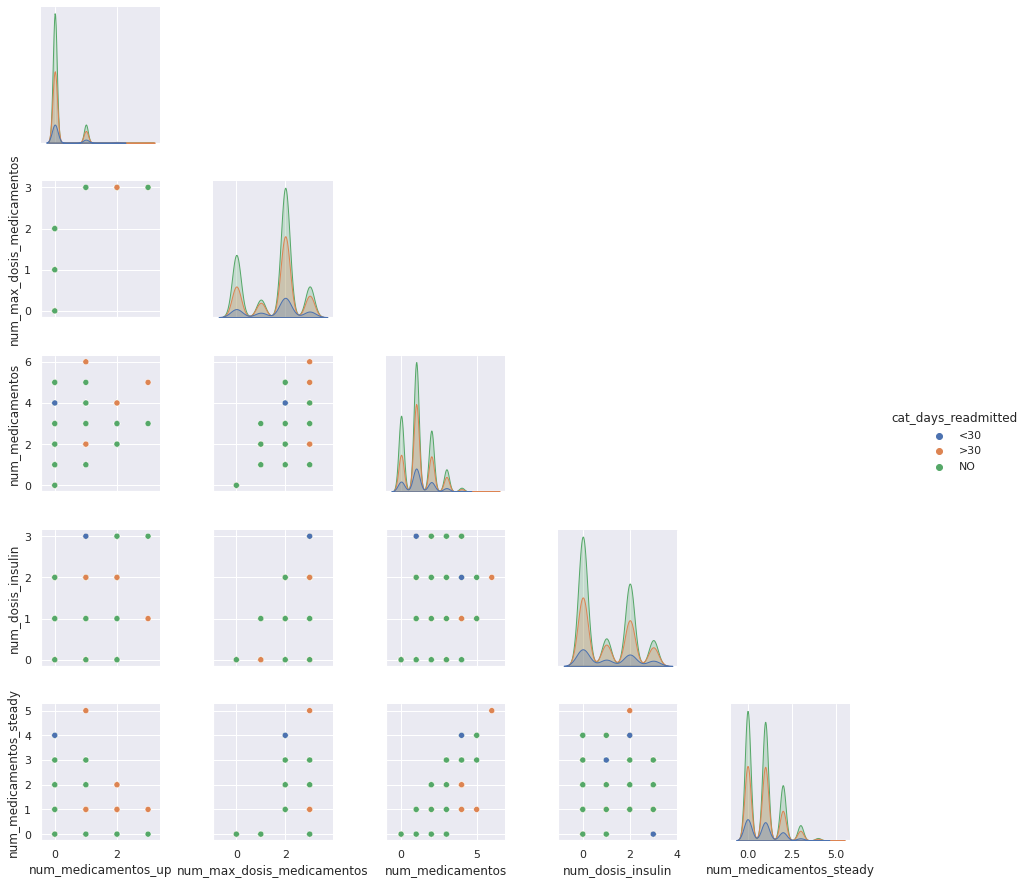

In [38]:
sns.pairplot(data= diabetes_final[top_correlated_vars+['cat_days_readmitted']].sample(n= 10000),
             hue= 'cat_days_readmitted',
             corner= True)



# Modelado

In [39]:
X = diabetes_final.drop(columns= ['encounter_id','patient_nbr','cat_days_readmitted'])
y = np.where(diabetes_final['cat_days_readmitted'] != 'NO', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 1234)



### estandarizar variables

In [40]:
min_max_scaler = MinMaxScaler()
min_max_scaler = min_max_scaler.fit(X_train)

scaled_vars = pd.DataFrame(min_max_scaler.transform(X_train), columns= X_train.columns.values)



### seleccionar variables

In [ ]:
rf = RandomForestClassifier(n_estimators= 100, min_weight_fraction_leaf= 0.01) 

rfecv = RFECV(estimator= rf, step= 10, cv= 3, scoring= 'roc_auc', verbose= 1, n_jobs= -1)

rfecv.fit(X_train, y_train)

In [ ]:
plt.figure()
plt.xlabel("Number of selected variables")
plt.ylabel("AUC")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()



### lanzar distintos algoritmos

In [42]:
features_selected = X_train.columns.values[rfecv.support_]

In [ ]:
'''
features_selected = ['num_days_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'num_outpatient', 'num_emergency',
       'num_inpatient', 'num_diagnoses', 'num_dosis_metformin',
       'num_dosis_insulin', 'num_medicamentos',
       'num_max_dosis_medicamentos', 'num_age', 'flag_take_medication',
       'flag_outpatient', 'flag_emergency', 'flag_diag_1_n410',
       'flag_diag_1_n491', 'flag_diag_1_n434', 'flag_diag_1_n577',
       'flag_diag_2_n250', 'flag_diag_2_n585', 'flag_diag_2_n285',
       'flag_asource_emergency_room',
       'flag_asource_transfer_from_a_hospital',
       'flag_asource_transfer_from_another_health_care_facility',
       'flag_dis_discharged_to_home',
       'flag_dis_dischargedtransferred_to_home_with_home_health_service',
       'flag_dis_expired']
'''

#### RF

In [43]:
params = {'n_estimators': [50,100],
          'min_weight_fraction_leaf': np.arange(0.01,0.15,0.02),
          'max_features': ['sqrt',1000]}

rf = GridSearchCV(RandomForestClassifier(), param_grid= params, cv= 3, scoring= 'roc_auc', n_jobs= -1, verbose= 1)

mdl_rf = rf.fit(X_train[features_selected],y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:   58.2s finished


In [44]:
y_pred_rf = mdl_rf.predict_proba(X_test[features_selected])[:,1]

#### GBM

In [45]:
params = {'learning_rate': np.arange(0.01,0.3,0.05),
          'n_estimators': [10,30,50],
          'max_depth': [3,5,7]}

gbm = GridSearchCV(GradientBoostingClassifier(), param_grid= params, cv= 3, scoring= 'roc_auc', n_jobs= -1, verbose= 1)

mdl_gbm = gbm.fit(X_train[features_selected],y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  7.8min finished


In [46]:
y_pred_gbm = mdl_gbm.predict_proba(X_test[features_selected])[:,1]

#### KNN

In [47]:
params = {'n_neighbors': np.arange(10,50,5)}

knn = GridSearchCV(KNeighborsClassifier(metric= 'euclidean', n_jobs= -1), param_grid= params, cv= 3, scoring= 'roc_auc', n_jobs= -1, verbose= 1)

mdl_knn = knn.fit(X_train[features_selected],y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  3.1min finished


In [48]:
y_pred_knn = mdl_knn.predict_proba(X_test[features_selected])[:,1]



### evaluar los algoritmos para determinar cuál es el que mejor

In [49]:
resultados = pd.DataFrame({'AUC': [roc_auc_score(y_test, y_pred_rf),
                                   roc_auc_score(y_test, y_pred_gbm),
                                   roc_auc_score(y_test, y_pred_knn)]},
                          index= ['RF','GBM','KNN'])

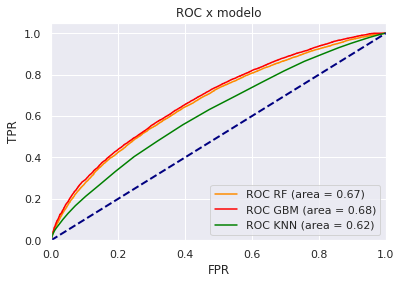

In [50]:
fpr = dict()
tpr = dict()

for i in range(3):
  fpr[i], tpr[i], _ = roc_curve(y_test, [y_pred_rf,y_pred_gbm,y_pred_knn][i])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color= 'darkorange', label='ROC RF (area = %0.2f)' % resultados.loc['RF'])
plt.plot(fpr[1], tpr[1], color= 'red', label='ROC GBM (area = %0.2f)' % resultados.loc['GBM'])
plt.plot(fpr[2], tpr[2], color= 'green', label='ROC KNN (area = %0.2f)' % resultados.loc['KNN'])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC x modelo')
plt.legend(loc="lower right")
plt.show()

### Matriz de cofusion para el mejor modelo

In [51]:
print('Accuracy: {:.1f}%'.format(accuracy_score(y_test, (y_pred_gbm > 0.5).astype('int'))*100),'\n'
      'Recall: {:.1f}%'.format(recall_score(y_test, (y_pred_gbm > 0.5).astype('int'))*100),'\n'
      'Presicion: {:.1f}%'.format(precision_score(y_test, (y_pred_gbm > 0.5).astype('int'))*100),'\n')

print('\nConfusion Matrix:\n', confusion_matrix(y_test, (y_pred_gbm > 0.5).astype('int')))

Accuracy: 63.3% 
Recall: 50.1% 
Presicion: 62.8% 


Confusion Matrix:
 [[12247  4182]
 [ 7032  7062]]




# EXTRA



### hacer un clustering de aquellos pacientes que por lo menos han sido readmitidos una vez 

In [73]:
# Filtro los datos
diabetes_final_filtro_1 = diabetes_final[(diabetes_final['cat_days_readmitted'] != 'NO')]
diabetes_final_filtro_2 = diabetes_final_filtro_1[features_selected].copy()

In [74]:
# Se normalizan los datos con MinMax()
from sklearn import preprocessing 

min_max_scaler = preprocessing.MinMaxScaler() 
df_escalado = min_max_scaler.fit_transform(diabetes_final_filtro_2)
df_escalado = pd.DataFrame(df_escalado) # Hay que convertir a DF el resultado.
df_escalado = df_escalado.rename(columns = {
0	:	'num_days_in_hospital'	,
1	:	'num_lab_procedures'	,
2	:	'num_procedures'	,
3	:	'num_medications'	,
4	:	'num_outpatient'	,
5	:	'num_emergency'	,
6	:	'num_inpatient'	,
7	:	'num_diagnoses'	,
8	:	'num_dosis_metformin'	,
9	:	'num_dosis_insulin'	,
10	:	'num_medicamentos'	,
11	:	'num_max_dosis_medicamentos'	,
12	:	'num_age'	,
13	:	'flag_take_medication'	,
14	:	'flag_outpatient'	,
15	:	'flag_emergency'	,
16	:	'flag_diag_1_n410'	,
17	:	'flag_diag_1_n491'	,
18	:	'flag_diag_1_n434'	,
19	:	'flag_diag_1_n577'	,
20	:	'flag_diag_2_n250'	,
21	:	'flag_diag_2_n585'	,
22	:	'flag_diag_2_n285'	,
23	:	'flag_asource_emergency_room'	,
24	:	'flag_asource_transfer_from_a_hospital'	,
25	:	'flag_asource_transfer_from_another_health_care_facility'	,
26	:	'flag_dis_discharged_to_home'	,
27	:	'flag_dis_dischargedtransferred_to_home_with_home_health_service'	,
28	:	'flag_dis_expired'	
})

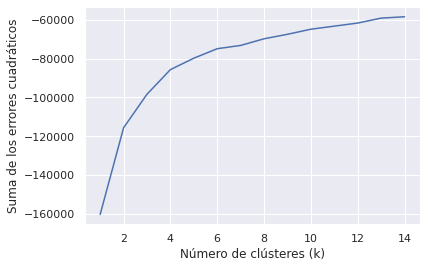

In [75]:
# Curva elbow para determinar valor óptimo de k.
nc = range(1, 15) # El número de iteraciones que queremos hacer.
kmeans = [KMeans(n_clusters=i) for i in nc]
score = [kmeans[i].fit(df_escalado).score(df_escalado) for i in range(len(kmeans))]
score
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Suma de los errores cuadráticos')
plt.plot(nc,score)

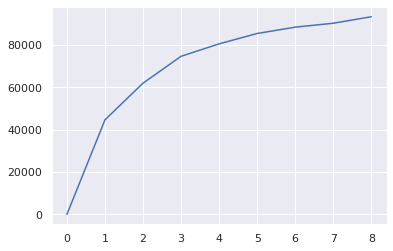

In [84]:
kMeansVar = [KMeans(n_clusters=k).fit(df_escalado.values) for k in range(1, 10)]
centroids = [X.cluster_centers_ for X in kMeansVar]
k_euclid = [cdist(df_escalado.values, cent) for cent in centroids]
dist = [np.min(ke, axis=1) for ke in k_euclid]
wcss = [sum(d**2) for d in dist]
tss = sum(pdist(df_escalado.values)**2)/df_escalado.values.shape[0]
bss = tss - wcss
plt.plot(bss)
plt.show()

In [106]:
# Vemos que a partir del 3 cluster cambia mucho la pendiente
new_features = df_escalado.drop('flag_dis_expired', axis= 1).columns.values
kmeans = KMeans(n_clusters= 3).fit(df_escalado[new_features])
labels = kmeans.predict(df_escalado[new_features])
diabetes_final_filtro_2['label'] = labels

In [108]:
# Media de variables por clusters
diabetes_final_filtro_2.groupby('label')[new_features].mean().T

label,0,1,2
num_days_in_hospital,4.796889,4.661645,4.390932
num_lab_procedures,44.418237,42.655044,44.702803
num_procedures,1.210952,1.281821,1.254115
num_medications,16.374225,15.921632,16.754915
num_outpatient,0.385987,0.420165,0.439517
num_emergency,0.252561,0.242327,0.231258
num_inpatient,0.948906,0.857312,0.903208
num_diagnoses,7.600734,7.590724,7.735538
num_dosis_metformin,0.403693,0.394324,0.342348
num_dosis_insulin,1.135197,1.051004,1.136535


Vemos que las diferencias mas importantes que hay entre cada cluster tienen que ver mas con los tipos de diagnosticos. Estando en el cluster 1 una mayor proporsion de pacientes con un segundo diagnostico referido a problemas en sangre, nutrientes y del sistema genitourinario; el cluster 0 con problemas en los sistemas circulatorios, respiratorios y digestivos; por ultimo, el cluster 2 se diferencia de los otros dos al ser pacientes de todo tipo de diagnosticos.

In [109]:
# Desviacion Estandar de variables por clusters
diabetes_final_filtro_2.groupby('label')[new_features].std().T

label,0,1,2
num_days_in_hospital,3.159312,3.061795,2.875631
num_lab_procedures,19.510387,19.444754,19.209664
num_procedures,1.673899,1.487318,1.789443
num_medications,7.591950,7.512348,7.407057
num_outpatient,0.961172,0.997487,1.055350
num_emergency,0.659500,0.644081,0.625407
num_inpatient,1.417580,1.323705,1.371305
num_diagnoses,1.883212,1.830009,1.745831
num_dosis_metformin,0.815469,0.811079,0.767167
num_dosis_insulin,1.115087,1.096482,1.110402
